In [1]:
import numpy as np
import pandas as pd
import nbimporter
import dynamicalModels as dynamicalModels
from Spectral_Domain_Granger_Analysis_Part_1 import *
import ipdb
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.tsatools import detrend
import statsmodels
import matplotlib.pyplot as plt


from scipy.fftpack import fftfreq
from scipy.signal import csd, welch

Importing Jupyter notebook from dynamicalModels.ipynb
Importing Jupyter notebook from Spectral_Domain_Granger_Analysis_Part_1.ipynb


In [2]:
def spectral_granger_freq(var1,var2,df,time_lag=0,fs=1.0,nperseg=1024):
    estimate_causality_var22var1 = []
    estimate_causality_var12var2 = []
    #ipdb.set_trace()
    #get set of frequences
    model = VAR(df)
    
    if time_lag == 0:
        #find optimal lag order by Akaike information criteria
        lag_orders_data = model.select_order(trend='nc')
        time_lag = lag_orders_data.selected_orders['aic']
    elif isinstance(time_lag, str):
        #find optimal lag order by Akaike information criteria
        lag_orders_data = model.select_order(trend='nc')
        time_lag = lag_orders_data.selected_orders[time_lag]

    #fit to optimal BIC lag number
    results = model.fit(time_lag,trend='nc')
    
    #generate dft frequencies 
    
    frequencies_array = fftfreq(nperseg)
    fir_half_freq = frequencies_array[:int(nperseg/2)]
    sec_half_freq = frequencies_array[int(nperseg/2):]
    frequencies_array = np.concatenate((sec_half_freq,fir_half_freq), axis=0)
    
    
    ind_var1 = df.columns.get_loc(var1)
    ind_var2 = df.columns.get_loc(var2)
    
    Sigma = np.cov((results.resid.values).T)

    #define transfer function 
    def H(f):
        return transfer_fun(f,results.coefs)
    
    #define spectral density function 
    def estimate_spectral_density(f):
        return estimate_spectral_density_matrix(f,Sigma,results.coefs)
        

    #I'm not sure what to do here
    for f in frequencies_array:
        H_mat = H(f)
        
        est_S = estimate_spectral_density(f)
        
        var22var1entry = -np.log(1- (Sigma[ind_var2,ind_var2] - \
            (Sigma[ind_var1,ind_var2]**2/Sigma[ind_var1,ind_var1]))*np.absolute(H_mat[ind_var1,ind_var2])**2/est_S[ind_var1,ind_var1].real)
        
        var12var2entry = -np.log(1- (Sigma[ind_var1,ind_var1] - \
            (Sigma[ind_var1,ind_var2]**2/Sigma[ind_var2,ind_var2]))*np.absolute(H_mat[ind_var2,ind_var1])**2/est_S[ind_var2,ind_var2].real) 
        
        estimate_causality_var22var1.append(var22var1entry)
        estimate_causality_var12var2.append(var12var2entry)
    
    scaled_freq= frequencies_array*fs
    return [frequencies_array,estimate_causality_var22var1,estimate_causality_var12var2]

# Van der Pool Oscillator

Step 1a: Generate data from Van der Pool Oscillator

In [3]:
#x0 = np.array([-1.0/2, 2.0])
x0 = np.array([5.0, 5.0])
dt = 0.1
tinit = 0
tmax = 100
vdp = dynamicalModels.van_der_pol(2)

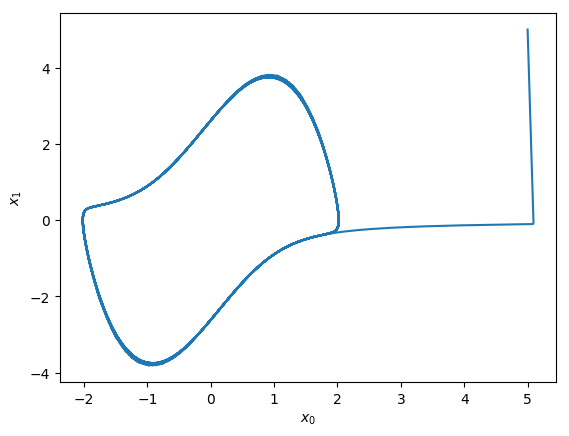

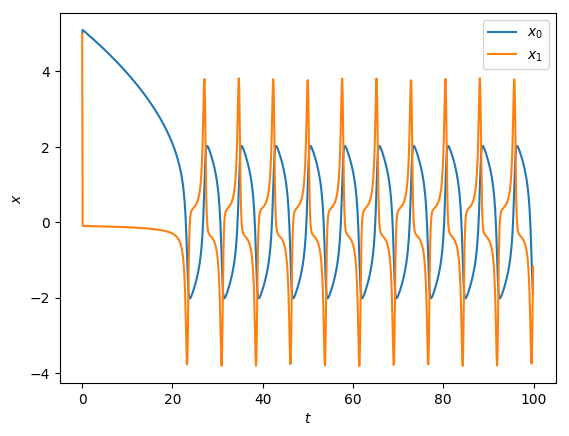

In [4]:
sol = vdp.integrate(tinit,tmax,dt,x0)
data_length =(sol.t).shape[0]
vdp.trajectory_plot()
vdp.evolution_plot()

Step 1b: Prepare data 

In [5]:
vdp_df = pd.DataFrame(data=(sol.y).T,    
                columns=['x','dx'])

#detrend 
vdp_df = vdp_df.diff()
vdp_df = vdp_df.dropna()

Step 2: Compute Spectral Correlation

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


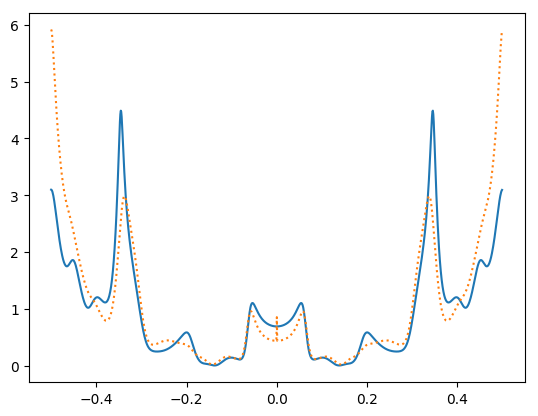

In [6]:
[frequencies_array,estimate_causality_var22var1,estimate_causality_var12var2] = \
        spectral_granger_freq('x','dx',vdp_df,time_lag='aic',fs=1/dt)

plt.clf()
plt.plot(frequencies_array,estimate_causality_var22var1)
plt.plot(frequencies_array,estimate_causality_var12var2,':')
plt.show()

# Van der Pool with noise added to the dynamical  data

Step 1a: Generate data

In [7]:
x0 = np.array([5.0, 5.0])
dt = 0.1
tinit = 0
tmax = 100
vdp = dynamicalModels.van_der_pol(2)

sol = vdp.integrate(tinit,tmax,dt,x0)
data_length =(sol.t).shape

In [8]:
#add noise
length_vdp = sol.y[0,:].shape[0]
y = sol.y
y[0,:] = sol.y[0,:] + np.random.normal(scale=0.1,size=length_vdp)
y[1,:] = sol.y[1,:] + np.random.normal(scale=0.1,size=length_vdp)

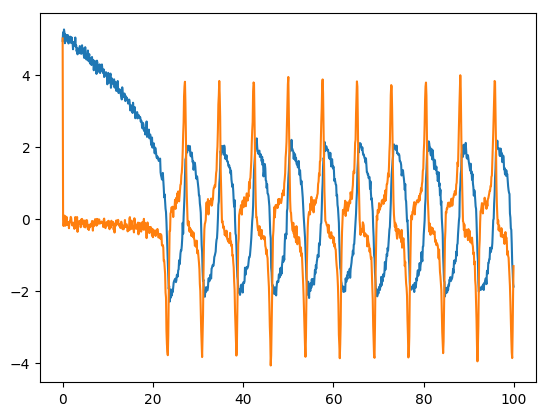

In [9]:
plt.plot(sol.t,y.T)
plt.show()

Step 1b: Prepare data

In [10]:
vdp_df = pd.DataFrame(data=y.T,    
                columns=['x','dx'])

#detrend 
vdp_df = vdp_df.diff()
vdp_df = vdp_df.dropna()

Step 2: Compute Spectral Correlation

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


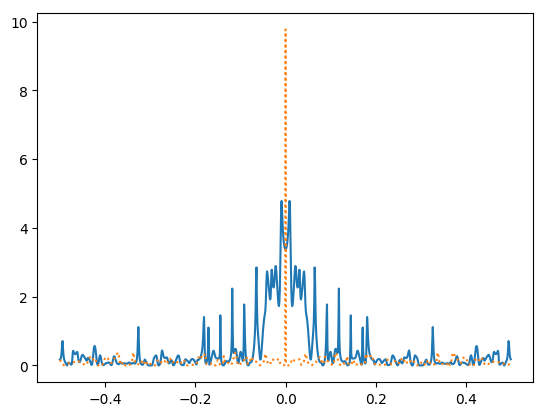

In [11]:
[frequencies_array,estimate_causality_var22var1,estimate_causality_var12var2] = \
        spectral_granger_freq('x','dx',vdp_df,time_lag=100,fs=1/dt)

plt.clf()
plt.plot(frequencies_array,estimate_causality_var22var1)
plt.plot(frequencies_array,estimate_causality_var12var2,':')
plt.show()

# Weiner Process

Step 1a: Generate data

In [12]:
def a_fun(X):
    return (3-X)
def b_fun(X):
    return 1

#create four independently sample Weiner Process
sodes= dynamicalModels.sdes(a_fun,b_fun)
N=1000
y = np.zeros([3,N])
dt=0.1
tinit=0.0
tmax=20.0
dt = (tinit-tmax)/(N-1)
for i in range(3): 
    x0 = 10*(2*np.random.uniform(size=1)-1)
    out = sodes.euler_maruyama(tinit,x0,tmax,N)
    y[i,:] = out[1]
t = out[0]

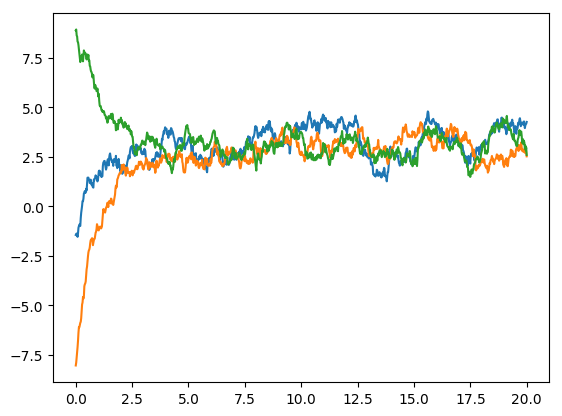

In [13]:
plt.plot(t,y.T)
plt.show()

Step 1b: Prepare data

In [14]:
wiener_df = pd.DataFrame(data=y.T,    
                columns=['x0','x1','x2'])

#detrend
wiener_df = wiener_df.diff()
wiener_df = wiener_df.dropna()

Step 2: Compute Spectral Correlation

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


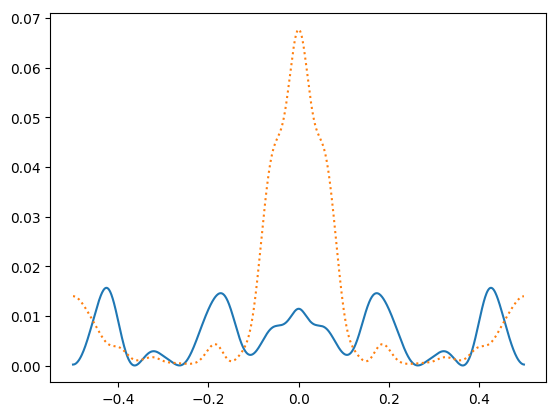

In [15]:
[frequencies_array,estimate_causality_var22var1,estimate_causality_var12var2] = \
        spectral_granger_freq('x0','x1',wiener_df,time_lag=10,fs=1/dt)

plt.clf()
plt.plot(frequencies_array,estimate_causality_var22var1)
plt.plot(frequencies_array,estimate_causality_var12var2,':')
plt.show()

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


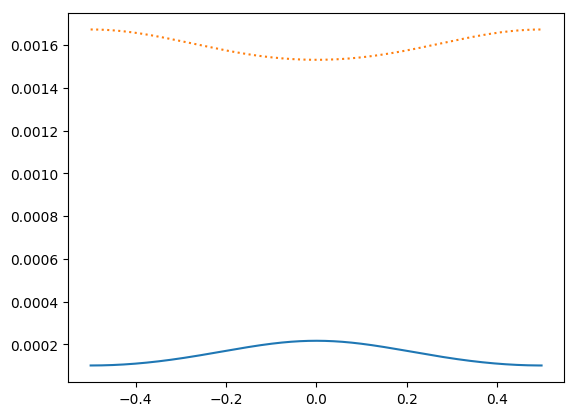

In [16]:
[frequencies_array,estimate_causality_var22var1,estimate_causality_var12var2] = \
        spectral_granger_freq('x0','x1',wiener_df,time_lag='aic',fs=1/dt)

plt.clf()
plt.plot(frequencies_array,estimate_causality_var22var1)
plt.plot(frequencies_array,estimate_causality_var12var2,':')
plt.show()

# Kuramoto Model: Strong Coupling

Step 1a: Generate data

In [17]:
# these are our constants
N = 3  # number of variables
K = 10 #coupling
omega =  np.array([3.07139979, 0.07936669, 2.63766864])   # natural frequency
theta0 = np.array([1.46606489, 1.66029349, 0.17308032]) # initial state 
tinit = 0.0
tmax = 30.0
dt =  0.01

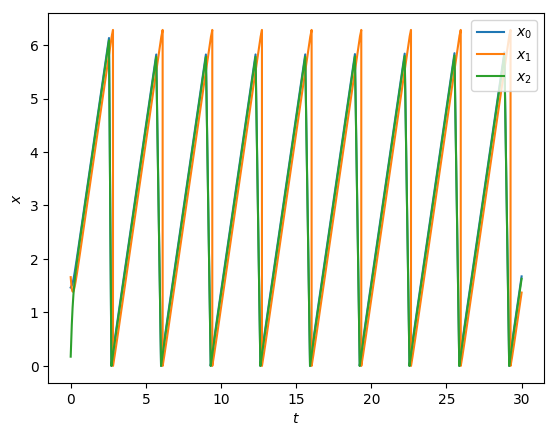

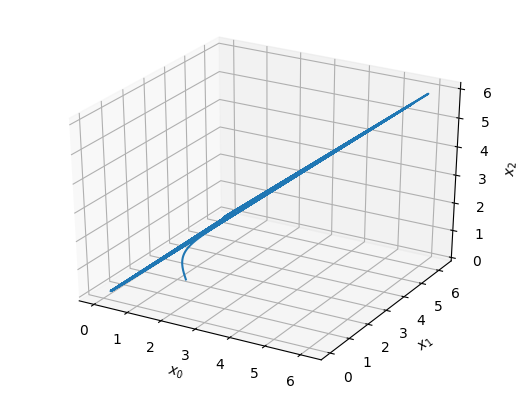

In [18]:
kuramoto = dynamicalModels.Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)

kuramoto.evolution_plot()
kuramoto.trajectory_plot()

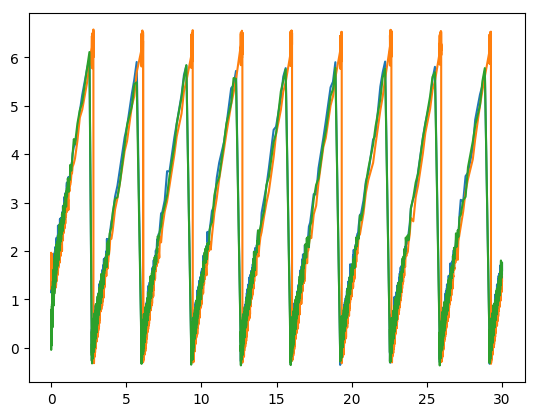

In [19]:
y=sol[1].T
length_y =y.shape[1]
for i in range(0,N):
    y[i,:]=y[i,:]+ np.random.normal(scale=0.1,size=length_y)
    
plt.plot(sol[0],y.T)
plt.show()

Step 1b: Prepare data

In [20]:
kura_df = pd.DataFrame(data=y.T,    
                columns=['x0','x1','x2'])

#detrend
kura_df = kura_df.diff()
kura_df = kura_df.dropna()

Step 2: Compute Spectral Correlation

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


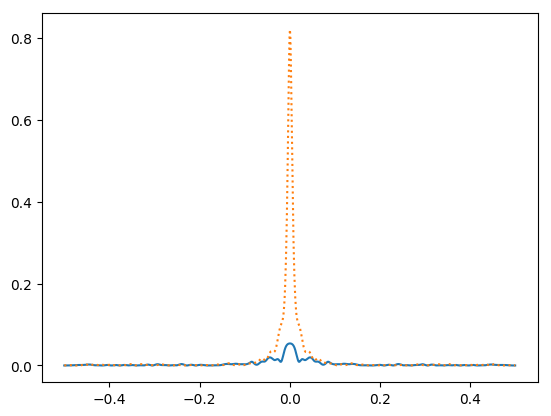

In [21]:
[frequencies_array,estimate_causality_var22var1,estimate_causality_var12var2] = \
        spectral_granger_freq('x1','x2',kura_df,time_lag='aic')

plt.clf()
plt.plot(frequencies_array,estimate_causality_var22var1)
plt.plot(frequencies_array,estimate_causality_var12var2,':')
plt.show()